In [10]:
import gc

from pathlib import Path

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit, GroupKFold #train_test_split, RepeatedKFold
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor

from custom.preprocessing import load_and_merge_data, preserve_geometry, _add_shrid_to_mosaiks, _merge_mosaiks_and_secc
from custom.shrug_data import lengthen_shapefile_ID_names, load_shrug_shapefiles, load_shrug_secc
from custom.evaluation import show_results, plot_prediction_maps
from custom.mosaiks_data import load_mosaiks_data
from custom.utils import load_gdf, latlon_df_to_gdf

In [2]:
DATA_ROOT = "/home/jovyan/ds_nudge_up/data/"

## Load data

Mosaiks features (with latlons)

In [3]:
mosaiks_path = DATA_ROOT+"/01_preprocessed/mosaiks_features/"
mosaiks_features = pd.read_parquet(mosaiks_path+'mosaiks_2013_landsat8_10000_points.parquet')

mosaiks_features_gdf = latlon_df_to_gdf(mosaiks_features)

SHRUG geometries

In [5]:
shrug_key_geoms = load_gdf(
    "01_preprocessed/SHRUG/shrug_pc11r_key_with_shapes",
    "shrug_pc11r_key_with_shapes.shp",
)
shrug_key_geoms = lengthen_shapefile_ID_names(shrug_key_geoms)
shrug_key_geoms = preserve_geometry(shrug_key_geoms, level="village")

SHRUG SECC

In [6]:
shrug_secc = load_shrug_secc()

Merge Mosaiks featues and SECC target via village shapes

In [7]:
mosaiks_features_gdf = _add_shrid_to_mosaiks(mosaiks_features_gdf, shrug_key_geoms)

In [8]:
gdf = _merge_mosaiks_and_secc(mosaiks_features_gdf, shrug_secc)

In [9]:
## old
# gdf = load_and_merge_data()

In [11]:
del shrug_key_geoms
del shrug_secc
del mosaiks_features_gdf
gc.collect()

0

## Pre-process data

In [14]:
# Select target
y_name = "secc_pov_rate_rural"

In [15]:
# drop rows with unavailable target
gdf_clean = gdf.dropna(subset=y_name)

In [16]:
# select list of columns to drop from the data so only features and target are left
shrug_key_cols = [
    "pc11_state_id",
    "pc11_district_id",
    "pc11_subdistrict_id",
    "pc11_village_id",
    "tv_name",
    "shrid",
    "pc11_v_uid",
    "geometry",
    "geometry_village"
]
geo_cols = ["lat", "lon"] + shrug_key_cols

shrug_secc_cols = [
    "shrid",
    "secc_inc_cultiv_share",
    "nco2d_cultiv_share",
    "secc_cons_pc_rural",
    "secc_cons_pc_urban",
    "secc_pov_rate_rural",
    "secc_pov_rate_urban",
    "secc_pov_rate_tend_rural",
    "secc_pov_rate_tend_urban",
    "num_members_mean_rural",
    "num_members_mean_urban",
]
shrug_secc_cols.remove(y_name)

cols_to_drop = list(shrug_secc_cols) + geo_cols

In [17]:
# select features and target
X = gdf_clean.drop(cols_to_drop + [y_name], axis=1)
y = gdf_clean[y_name]

Grouped train-test split: making sure that datapoints from the same village don't get split across train and test datasets (to avoid leakage).

Can change grouping variable to larger scale if needed (e.g. unique subdistrict IDs, etc)

In [18]:
# choose train/test indices
grouping_var = "pc11_v_uid"
splitter = GroupShuffleSplit(test_size=0.20, n_splits=1, random_state=0)
split = splitter.split(gdf_clean, groups=gdf_clean[grouping_var])
train_index, test_index = list(split)[0]

# split data into train and test
X_train, X_test, y_train, y_test = (
    X.iloc[train_index],
    X.iloc[test_index],
    y.iloc[train_index],
    y.iloc[test_index],
)

## Model A
Datapoints = latlong points

### Train model

In [19]:
model = Ridge()
model.fit(X_train, y_train) #, sample_weight=y_train

Ridge()

- target distribution
- optimise model

In [20]:
# # or with parameter search (grouped k-fold)

# group_kfold = GroupKFold(n_splits=5)
# cv_grouped = group_kfold.split(X, y, gdf_clean[grouping_var])

# model = RidgeCV(alphas=[0.01, 1, 10], cv=cv_grouped)
# model.fit(X_train, y_train, sample_weight=y_train)

# # summarize chosen configuration
# print('alpha: %f' % model.alpha_)

### Test

Next, we use the trained model to make predictions in the test set.

In [21]:
y_pred = model.predict(X_test)

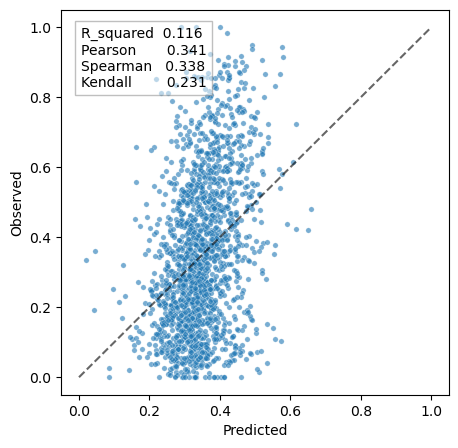

In [22]:
show_results(y_test, y_pred, file_name="results")

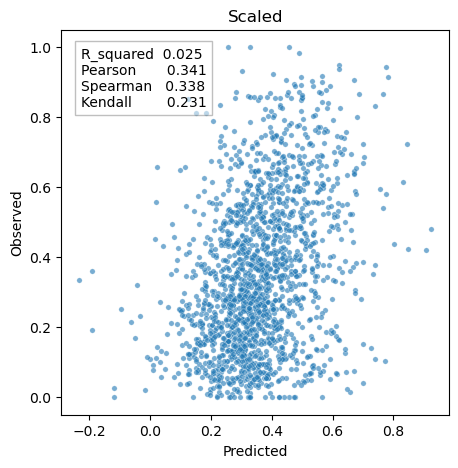

In [23]:
y_pred_scaled = ((y_pred - 0.15) / (0.7 - 0.15))
show_results(y_test, y_pred_scaled, file_name="results_scaled", line=False, title="Scaled")

Maps

In [24]:
# select dataframe with only test target and location data
gdf_clean_test_y = gdf_clean.iloc[test_index][geo_cols + [y_name]]

# add predicted values
gdf_clean_test_y.loc[:, "predicted"] = y_pred
gdf_clean_test_y.loc[:, "predicted_scaled"] = y_pred_scaled

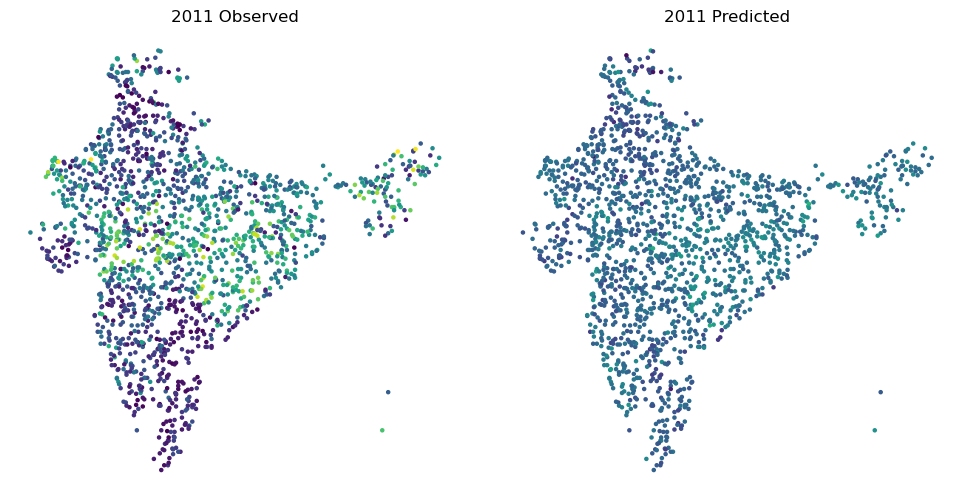

In [25]:
plot_prediction_maps(gdf_clean_test_y, y_name, "predicted", False, 0, 1, "points_prediction_map")

### Aggregate to `Subdistricts`

In [26]:
print("Total test datapoints: ", gdf_clean_test_y.shape[0])

Total test datapoints:  1737


In [27]:
sd_shapes = load_shrug_shapefiles(level="subdistrict")
sd_shapes["geometry_subdistrict"] = sd_shapes["geometry"]

In [28]:
gdf_clean_test_y_subdistricts = gdf_clean_test_y.sjoin(sd_shapes)

# change default geometry to subdistricts (for plotting)
gdf_clean_test_y_subdistricts["geometry_point"] = gdf_clean_test_y_subdistricts["geometry"]
gdf_clean_test_y_subdistricts["geometry"] = gdf_clean_test_y_subdistricts["geometry_subdistrict"]

Datapoints with unique subdistricts:  1315


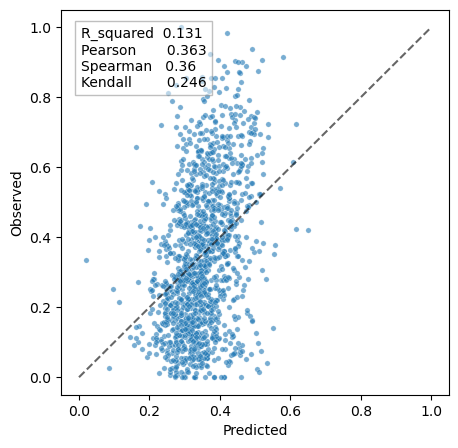

In [29]:
subdistrict_ys = gdf_clean_test_y_subdistricts.groupby(
    [
        "pc11_state_id",
        "pc11_district_id",
        "pc11_subdistrict_id"
    ],
    as_index=False,
)[[y_name, "predicted"]].mean()
print("Datapoints with unique subdistricts: ", subdistrict_ys.shape[0])

show_results(subdistrict_ys[y_name], subdistrict_ys["predicted"], file_name="results_subdistricts")

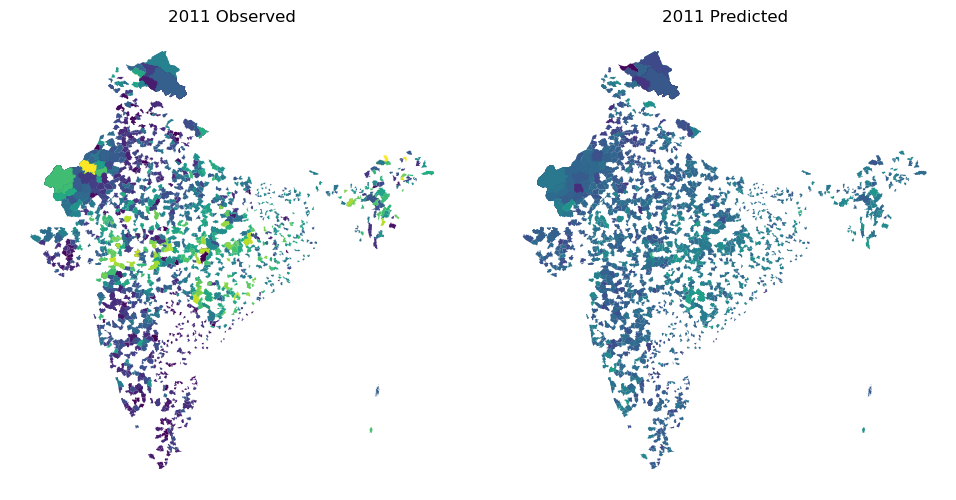

In [30]:
plot_prediction_maps(gdf_clean_test_y_subdistricts, y_name, "predicted", False, 0, 1, "subdistricts_prediction_map")

#### Binarise poverty levels using quantiles

In [31]:
# binarise target using quantiles
gdf_clean_test_y_subdistricts.loc[:, "target_binarised"] = pd.qcut(gdf_clean_test_y_subdistricts[y_name], q=2, labels=False)

In [32]:
gdf_clean_test_y_subdistricts[y_name+"top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts[y_name], q=5, labels=False) == 4) * 1
gdf_clean_test_y_subdistricts["predicted_top_20_perc"] = (pd.qcut(gdf_clean_test_y_subdistricts["predicted"], q=5, labels=False) == 4) * 1

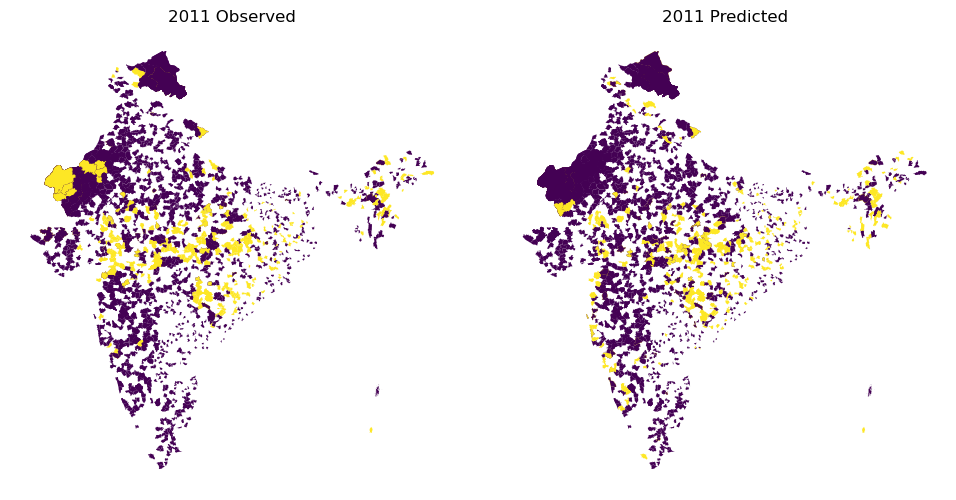

In [33]:
plot_prediction_maps(gdf_clean_test_y_subdistricts, y_name+"top_20_perc", "predicted_top_20_perc", False, 0, 1, "subdistricts_prediction_map_top20")

4 quadrant metrics